In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Step 1: Install and Import Dependencies
!pip install torch torchvision
!pip install segmentation-models-pytorch --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.4 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import TensorDataset
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import tifffile as tiff
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score as f1_score_sklearn, accuracy_score


In [4]:
# Step 2: Define Dataset Class Using tifffile for .tif images and PIL for .png masks
class TiffPngSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_name = self.images[idx].replace('.tif', '.png')  # Assuming corresponding mask has the same name but .png extension
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = tiff.imread(img_path)
        mask = Image.open(mask_path).convert("L")

        # Convert to 3-channel image if necessary
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)  # Grayscale to RGB-like format

        # Convert image to tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # HWC to CHW

        # Convert mask to tensor
        mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)  # Add channel dimension for the mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [5]:
# Step 3: Define Transformations and Load Dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
])

# Update with the correct path to your data in Colab
train_dataset = TiffPngSegmentationDataset(images_dir= '/content/drive/MyDrive/Data/data/images', masks_dir= '/content/drive/MyDrive/Data/data/labels', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [9]:
from sklearn.model_selection import train_test_split

# Step 3: Split Dataset into Train, Validation, and Test sets
def train_val_test_split(images_dir, masks_dir, test_size=0.2, val_size=0.1):
    images = os.listdir(images_dir)

    # First, split into train+val and test
    train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    # Now, split train+val into train and val
    train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

    return train_images, val_images, test_images

images_dir= '/content/drive/MyDrive/Data/data/images'

masks_dir= '/content/drive/MyDrive/Data/data/labels'

# Split the dataset
train_images, val_images, test_images = train_val_test_split(images_dir, masks_dir)

# Create Datasets for train, validation, and test
train_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)
val_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)
test_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)

# Create DataLoaders for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [19]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import torch.optim as optim

# Step 1: Pre-process input with a 1x1 convolution to reduce channels from 12 to 3
pre_conv = nn.Conv2d(12, 3, kernel_size=1)

# Step 2: Load Pretrained U-Net Model
model = smp.Unet(
    encoder_name="resnet34",        # Choose encoder: resnet34
    encoder_weights="imagenet",     # Use pretrained weights on ImageNet
    in_channels=3,                  # Input channels after the 1x1 convolution
    classes=1,                      # Output classes (1 for binary segmentation)
    activation=None                 # No activation function applied in the output
)

# Step 3: Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 4: Transfer the model and pre-conv layer to the device
pre_conv.to(device)
model.to(device)

# Step 5: Define forward pass function (to replicate the original class-based approach)
def forward(x):
    x = pre_conv(x)  # Apply 1x1 convolution to reduce the input channels
    return model(x)


In [11]:
# Step 5: Define Loss, Optimizer, and Accuracy Function
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 5: Corrected Accuracy Function
def accuracy(preds, labels):
    preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities
    preds = (preds > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)

    correct = (preds == labels).float()  # Check for equality, returns 1 where equal and 0 otherwise
    acc = correct.sum() / correct.numel()  # Divide by total number of elements (pixels)
    return acc



In [17]:
import torch
import torch.nn.functional as F

def dice_coefficient(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()  # Convert probabilities to binary values
    y_true = y_true.float()

    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true)

    dice = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice

def dice_loss(y_pred, y_true, threshold=0.5):
    return 1 - dice_coefficient(y_pred, y_true, threshold)

def f1_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    precision = intersection / (pred.sum() + 1e-6)
    recall = intersection / (target.sum() + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    return f1



In [13]:
def f1_score(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()  # Convert probabilities to binary values
    y_true = y_true.float()

    tp = torch.sum(y_pred * y_true)
    fp = torch.sum(y_pred * (1 - y_true))
    fn = torch.sum((1 - y_pred) * y_true)

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1


In [23]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, pre_conv, train_loader, val_loader, num_epochs=50, lr=1e-4, threshold=0.5):
    # Define loss function and optimizer
    bce_loss = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with logits
    optimizer = optim.Adam(list(pre_conv.parameters()) + list(model.parameters()), lr=lr)

    # Move the pre_conv layer and model to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pre_conv.to(device)
    model.to(device)

    # Initialize metrics tracking
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    train_f1_scores = []
    val_f1_scores = []
    val_accuracies = []  # Track validation accuracy

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_dice = 0.0
        running_f1 = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients

            # Forward pass
            outputs = forward(inputs)

            # Compute losses
            loss_bce = bce_loss(outputs, labels)
            loss_dice = dice_loss(torch.sigmoid(outputs), labels, threshold)
            loss = loss_bce + loss_dice  # Combine BCE and Dice loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)  # Accumulate loss

            # Calculate Dice and F1 scores
            dice_score = dice_coefficient(torch.sigmoid(outputs), labels, threshold)
            f1 = f1_score(torch.sigmoid(outputs), labels, threshold)

            running_dice += dice_score.item() * inputs.size(0)
            running_f1 += f1.item() * inputs.size(0)

            # Calculate training accuracy
            preds = torch.sigmoid(outputs) > threshold
            correct_train += (preds == labels).sum().item()
            total_train += labels.numel()

        # Calculate average metrics for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = running_dice / len(train_loader.dataset)
        epoch_f1 = running_f1 / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        train_losses.append(epoch_loss)
        train_dice_scores.append(epoch_dice)
        train_f1_scores.append(epoch_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Dice: {epoch_dice:.4f}, F1: {epoch_f1:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_dice = 0.0
        val_f1 = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = forward(inputs)

                loss_bce = bce_loss(outputs, labels)
                loss_dice = dice_loss(torch.sigmoid(outputs), labels, threshold)
                loss = loss_bce + loss_dice

                val_loss += loss.item() * inputs.size(0)

                # Calculate validation Dice and F1 scores
                dice_score = dice_coefficient(torch.sigmoid(outputs), labels, threshold)
                f1 = f1_score(torch.sigmoid(outputs), labels, threshold)

                val_dice += dice_score.item() * inputs.size(0)
                val_f1 += f1.item() * inputs.size(0)

                # Calculate validation accuracy
                preds = torch.sigmoid(outputs) > threshold
                correct_val += (preds == labels).sum().item()
                total_val += labels.numel()

        # Calculate average validation metrics for the epoch
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        val_f1 /= len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        val_f1_scores.append(val_f1)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, F1: {val_f1:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Plot Loss and Metrics for Train and Validation
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_dice_scores, label='Train Dice Score')
    plt.plot(epochs_range, val_dice_scores, label='Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Training and Validation Dice Score')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, train_f1_scores, label='Train F1 Score')
    plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_dice_scores, val_dice_scores, train_f1_scores, val_f1_scores, val_accuracies


Epoch 1/10, Training Loss: 0.2979, Dice: 0.8686, F1: 0.8686, Training Accuracy: 0.9369
Epoch 1/10, Validation Loss: 0.3007, Dice: 0.8765, F1: 0.8765, Validation Accuracy: 0.9356
Epoch 2/10, Training Loss: 0.2924, Dice: 0.8682, F1: 0.8682, Training Accuracy: 0.9394
Epoch 2/10, Validation Loss: 0.2417, Dice: 0.8941, F1: 0.8941, Validation Accuracy: 0.9484
Epoch 3/10, Training Loss: 0.2583, Dice: 0.8868, F1: 0.8868, Training Accuracy: 0.9459
Epoch 3/10, Validation Loss: 0.2314, Dice: 0.8965, F1: 0.8965, Validation Accuracy: 0.9497
Epoch 4/10, Training Loss: 0.2380, Dice: 0.8956, F1: 0.8956, Training Accuracy: 0.9510
Epoch 4/10, Validation Loss: 0.2296, Dice: 0.9021, F1: 0.9021, Validation Accuracy: 0.9502
Epoch 5/10, Training Loss: 0.2429, Dice: 0.8920, F1: 0.8920, Training Accuracy: 0.9506
Epoch 5/10, Validation Loss: 0.2868, Dice: 0.8822, F1: 0.8822, Validation Accuracy: 0.9361
Epoch 6/10, Training Loss: 0.2308, Dice: 0.8999, F1: 0.8999, Training Accuracy: 0.9509
Epoch 6/10, Validation 

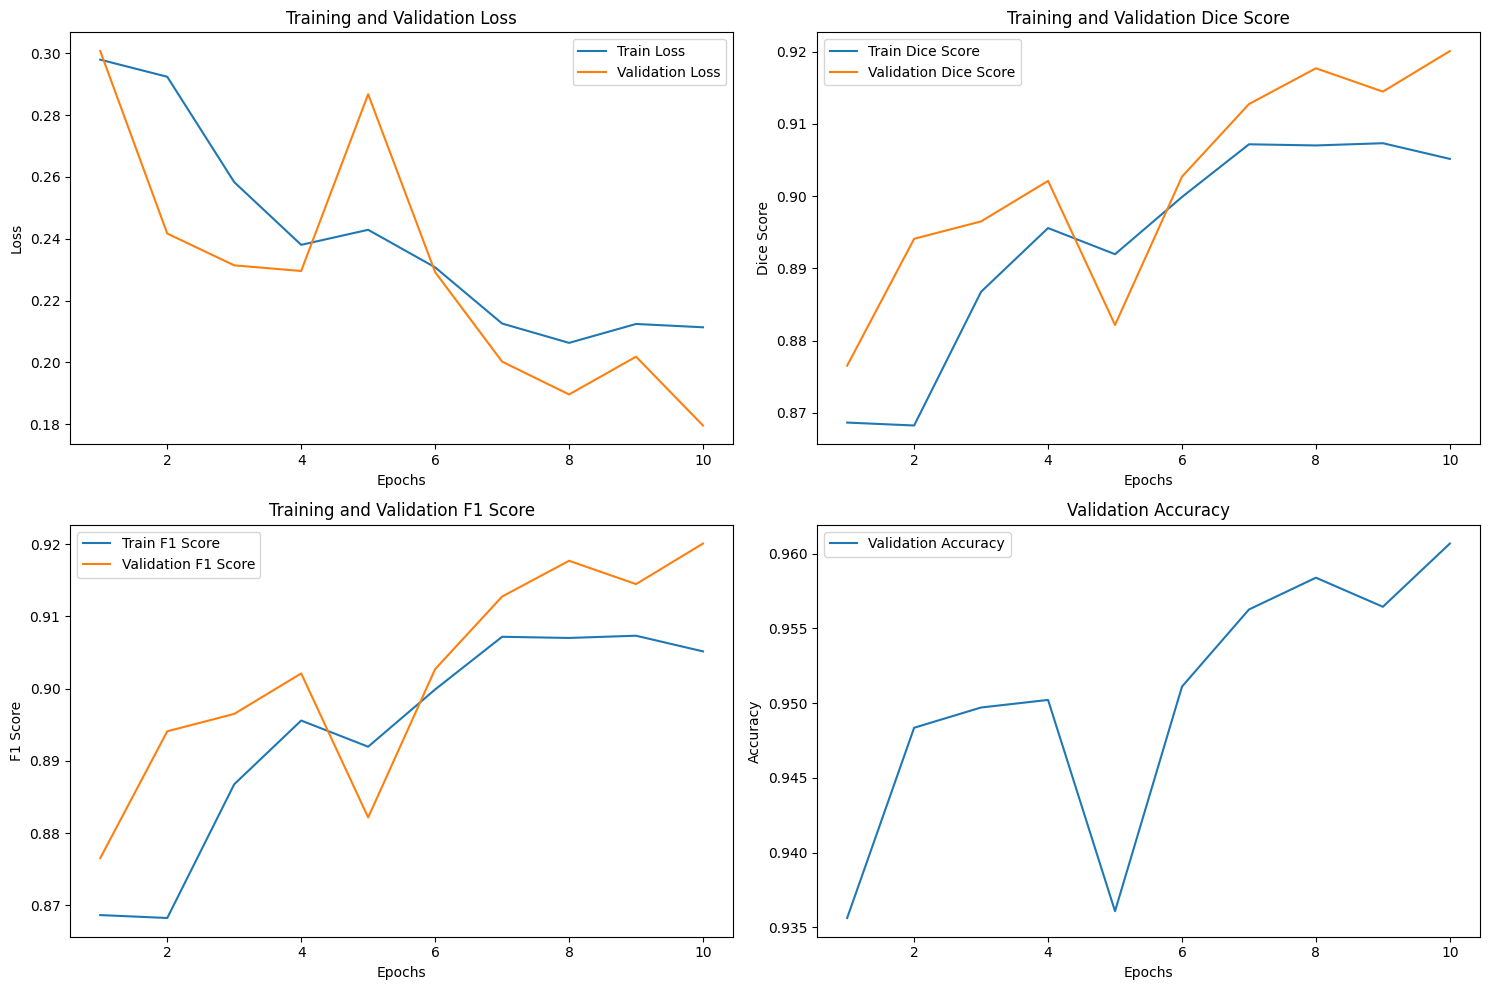

In [26]:
# Training parameters
num_epochs = 10
lr = 1e-4
threshold = 0.5

# Train the model
train_losses, val_losses, train_dice_scores, val_dice_scores, train_f1_scores, val_f1_scores , val_accuracies= train(
    model, pre_conv, train_loader, val_loader, num_epochs=num_epochs, lr=lr, threshold=threshold
)


Test Loss: 0.6206, Dice: 0.9201, F1: 0.9201, Accuracy: 0.9607


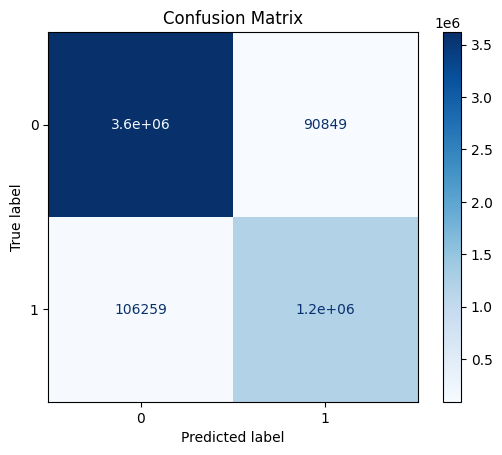

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()  # Set model to evaluation mode
bce_loss = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with logits

test_loss = 0.0
test_dice = 0.0
test_f1 = 0.0
correct_test = 0
total_test = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = forward(inputs)

        # Apply sigmoid to the outputs for binary classification
        outputs_sigmoid = torch.sigmoid(outputs)

        # Compute loss
        loss = bce_loss(outputs_sigmoid, labels)
        test_loss += loss.item() * inputs.size(0)

        # Calculate Dice and F1 scores
        dice_score = dice_coefficient(outputs_sigmoid, labels, threshold)
        f1 = f1_score(outputs_sigmoid, labels, threshold)

        test_dice += dice_score.item() * inputs.size(0)
        test_f1 += f1.item() * inputs.size(0)

        # Collect predictions and true labels for confusion matrix
        preds = (outputs_sigmoid > threshold).cpu().numpy().astype(int).flatten()
        labels = labels.cpu().numpy().astype(int).flatten()

        all_preds.extend(preds)
        all_labels.extend(labels)

# Calculate average metrics
test_loss /= len(test_loader.dataset)
test_dice /= len(test_loader.dataset)
test_f1 /= len(test_loader.dataset)

# Compute accuracy
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"Test Loss: {test_loss:.4f}, Dice: {test_dice:.4f}, F1: {test_f1:.4f}, Accuracy: {accuracy:.4f}")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [31]:
# Save the model and pre_conv layers
torch.save({
    'pre_conv_state_dict': pre_conv.state_dict(),
    'model_state_dict': model.state_dict(),
}, 'unet_model.pth')

print("Model saved successfully!")


Model saved successfully!
